In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

ticker = 'AAPL'
stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&limit=100&apikey={fm_key}').json()
stock_news = pd.DataFrame(stock_news)
stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC', 'Forbes', 'Barrons', 'Market Watch'])]

text_str = ' '.join(str(x) for x in stock_news['text'])

print(text_str)

Apple Inc. AAPL, +0.86% has pushed back a return to Apple Park and other offices until January 2022, its latest delay as it and other companies cope with a surge in COVID-19 cases and variants. The delay, reported by Bloomberg, citing an internal Apple memo, is the second in recent weeks for the iPhone maker, which had planned an October return. Apple has delayed its return to the office until January at the earliest, due to the spread of Covid-19 and new variants, Bloomberg reported Friday. Apple staff won't be returning to the office until January, amid fears over surging coronavirus cases. More and more companies are rethinking plans to go back to in-person work in September. UBS's Francois-Xavier Bouvignies said his firm has a "neutral" rating on French-Italian chip firm STMicroelectronics because of the company's exposure to Apple. Apple stock is trading at near all-time highs of about $150 per share, driven by anticipation surrounding the launch of the new iPhones in September. S

In [3]:
import gensim


In [4]:
from gensim.summarization import summarize

### 1. Summerization

In [5]:
import gensim
from gensim.summarization import summarize

text_summ = summarize(text_str)
print(text_summ)

Apple Inc. AAPL, +0.86% has pushed back a return to Apple Park and other offices until January 2022, its latest delay as it and other companies cope with a surge in COVID-19 cases and variants.
The delay, reported by Bloomberg, citing an internal Apple memo, is the second in recent weeks for the iPhone maker, which had planned an October return.
Apple has delayed its return to the office until January at the earliest, due to the spread of Covid-19 and new variants, Bloomberg reported Friday.


In [4]:
#from gensim.summarization.summarizer import summarize

ModuleNotFoundError: No module named 'gensim.summarization'

In [4]:
#pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [6]:
#pip install "gensim==3.8.1"

  Created wheel for gensim: filename=gensim-3.8.1-cp38-cp38-win_amd64.whl size=23720033 sha256=a1c72253fcbee4f4f73ac1b1b63e574c1fafdf7229bf1de058604c5d66c576b6
  Stored in directory: c:\users\jizha\appdata\local\pip\cache\wheels\33\de\03\7346ae70da7f980f78569668caf78fb2d678b176e549557c7d
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\jizha\\Anaconda3\\Lib\\site-packages\\~ensim\\corpora\\_mmreader.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



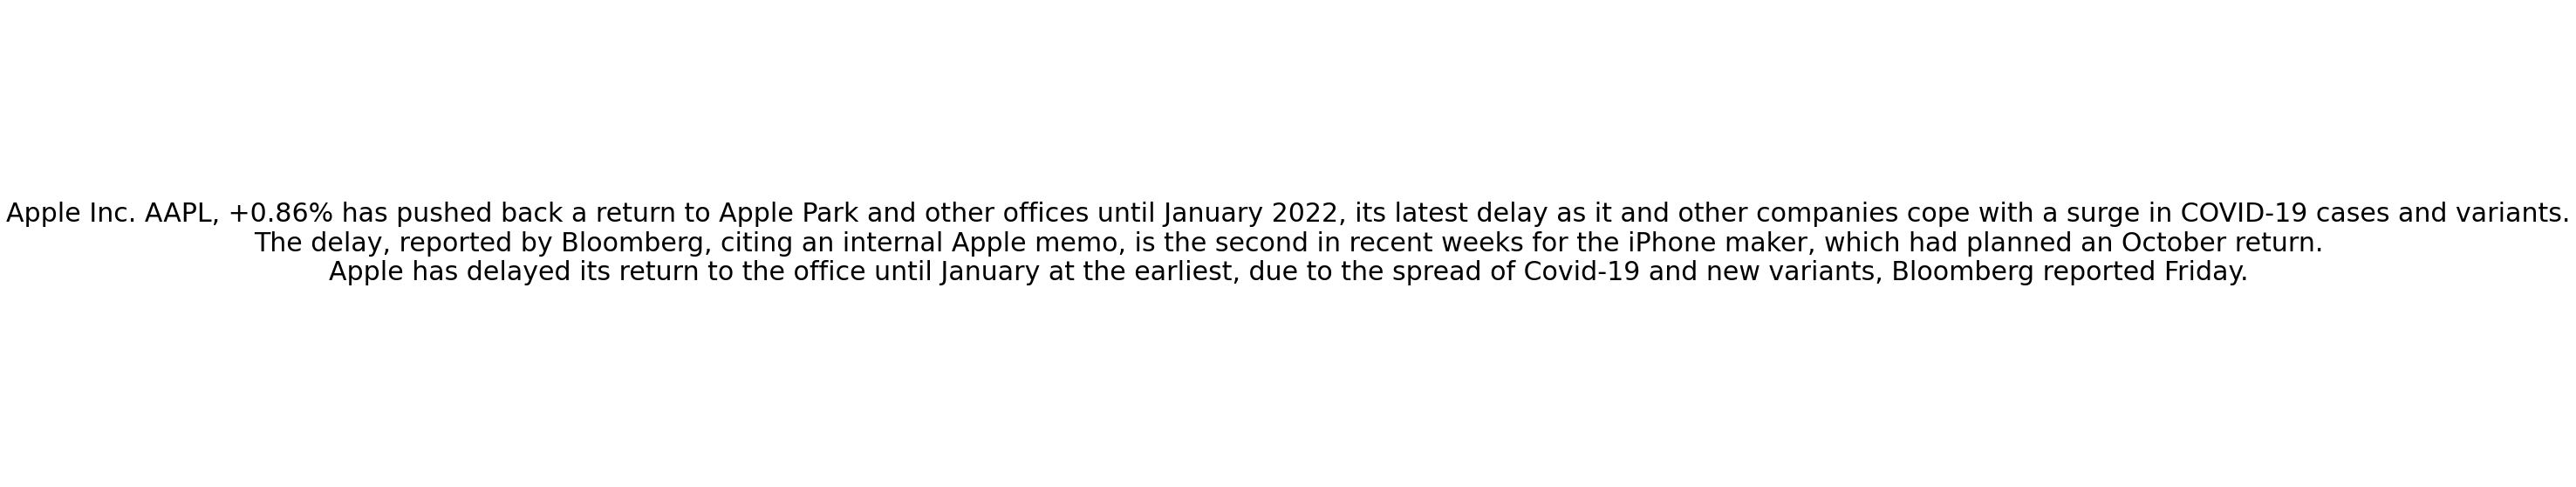

In [6]:
plt.figure(figsize = (10, 10))
sum_plot = text_summ.split(' .\n')
for i in range(len(sum_plot)):
    plt.text(0.1, 1 - (i+1)*0.5, sum_plot[len(sum_plot)-1-i], size = 30,\
             horizontalalignment='center', verticalalignment='center')
    
plt.axis('off')
plt.show()

### 2. Extraction with importance:   
- Refer to: https://medium.com/analytics-vidhya/sentence-extraction-using-textrank-algorithm-7f5c8fd568cd

In [12]:
import re
from pprint import pprint

import numpy as np
from nltk import sent_tokenize, word_tokenize

from nltk.cluster.util import cosine_distance

MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "
    

def is_blank(string):
    """
    Returns `True` if string contains only white-space characters
    or is empty. Otherwise `False` is returned.
    """
    return not string or string.isspace()


def get_symmetric_matrix(matrix):
    """
    Get Symmetric matrix
    :param matrix:
    :return: matrix
    """
    return matrix + matrix.T - np.diag(matrix.diagonal())


def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)

class TextRank4Sentences():
    
    def __init__(self):
        self.damping = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 100  # iteration steps
        self.text_str = None
        self.sentences = None
        self.pr_vector = None

    def _sentence_similarity(self, sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return core_cosine_similarity(vector1, vector2)
    
    def _build_similarity_matrix(self, sentences, stopwords=None):
        # create an empty similarity matrix
        sm = np.zeros([len(sentences), len(sentences)])

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

        # Get Symmeric matrix
        sm = get_symmetric_matrix(sm)

        # Normalize matrix by column
        norm = np.sum(sm, axis=0)
        sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

        return sm_norm

    def _run_page_rank(self, similarity_matrix):

        pr_vector = np.array([1] * len(similarity_matrix))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
            if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr_vector)

        return pr_vector
    
    def _get_sentence(self, index):

        try:
            return self.sentences[index]
        except IndexError:
            return ""

    def get_top_sentences(self, number=5):

        top_sentences = {}

        if self.pr_vector is not None:

            sorted_pr = np.argsort(self.pr_vector)
            sorted_pr = list(sorted_pr)
            sorted_pr.reverse()

            index = 0
            for epoch in range(number):
                #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                sent = self.sentences[sorted_pr[index]]
                sent = normalize_whitespace(sent)
                top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                index += 1

        return top_sentences
    
    def analyze(self, text, stop_words=None):
        self.text_str = text
        self.sentences = sent_tokenize(self.text_str)

        tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

        similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

        self.pr_vector = self._run_page_rank(similarity_matrix)
        
        #print(self.pr_vector)

tr4sh = TextRank4Sentences()
tr4sh.analyze(text_str)
top_sents = tr4sh.get_top_sentences(4)
top_sents

{"When Warren Buffett's Berkshire Hathaway reported the company's shareholdings for the first quarter of this year, the total value of the portfolio was $270.4 billion.": 1.3032959795653531,
 'We expect American Express to top the consensus estimates for revenues, while the earnings are likely to remain below expectations.': 1.2717479714628785,
 'American Express stock has gained around 42% YTD, increasing from about $121 at the beginning of 2021 to around $172 currently, significantly ahead of the S&P500, which grew 16% over the same period.': 1.2353091674650565,
 'The stock was the biggest advancer among the three of 30 Dow Jones Industrial Average members gaining ground.': 1.119653154119389}

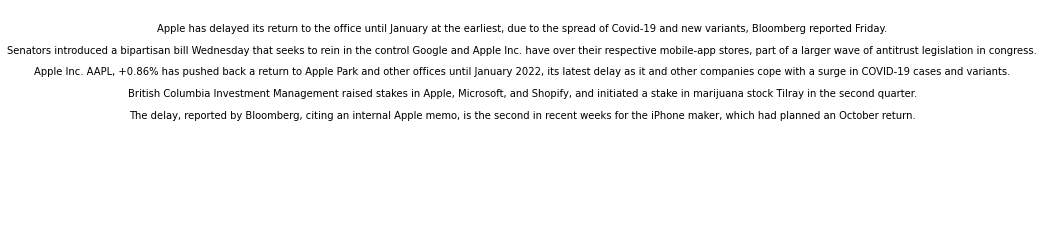

In [8]:
i = 1
for key in top_sents:
    plt.text(0.1, 1- i*0.1, key, horizontalalignment='center', verticalalignment='center')
    i = i + 1

plt.axis('off')
plt.show()

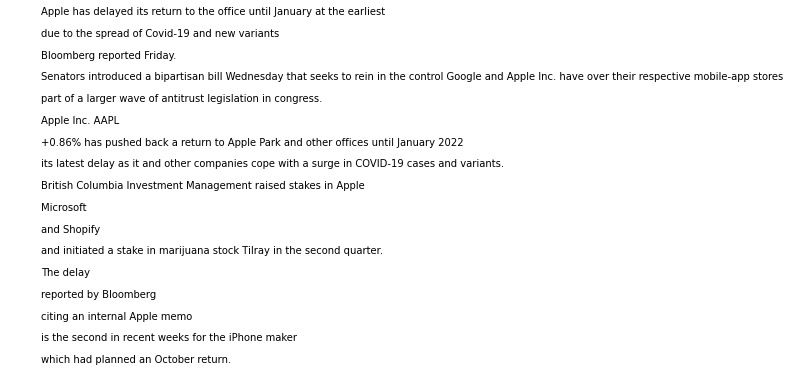

In [9]:
test = ', '.join(str(key) for key in top_sents)
# print(test)

test = test.split(', ')
# print(test)

for i in range(len(test)):
    plt.text(0.1, (i+1)*0.1, test[len(test)-1-i])
    
plt.axis('off')
plt.show()

### Plot:

In [45]:
# from io import BytesIO

# from matplotlib.figure import Figure
# import matplotlib.pyplot as plt
# from matplotlib.transforms import IdentityTransform

# def text_to_rgba(s, *, dpi, **kwargs):
#     # To convert a text string to an image, we can:
#     # - draw it on an empty and transparent figure;
#     # - save the figure to a temporary buffer using ``bbox_inches="tight",
#     #   pad_inches=0`` which will pick the correct area to save;
#     # - load the buffer using ``plt.imread``.
#     #
#     # (If desired, one can also directly save the image to the filesystem.)
#     fig = Figure(facecolor="none")
#     fig.text(0, 0, s, **kwargs)
#     buf = BytesIO()
#     fig.savefig(buf, dpi = dpi, format = "png", bbox_inches = "tight", pad_inches = 0)
#     buf.seek(0)
#     rgba = plt.imread(buf)
#     return rgba

# fig = plt.figure(figsize = (10,8))
# rgba_temp = text_to_rgba(r"what", color="blue", fontsize=20, dpi=200)
# fig.figimage(rgba_temp, 100, 50)
# fig.text(100, 350, r"some other string", color="red", fontsize=20, transform=IdentityTransform())
# plt.show()

In [46]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# wc = WordCloud(width = 6400, height = 6400,\
#                background_color = None, mode = "RGBA", min_font_size = 18).generate_from_frequencies(top_sents)
# plt.figure(figsize = (20, 20))
# plt.imshow(wc)
# plt.axis('off')
# plt.show()

In [47]:
# from PIL import Image, ImageDraw

# img = Image.new('RGB', (1600, 1600), color = (255, 255, 255))
# d = ImageDraw.Draw(img)

# t = 1
# for key in top_sents:
#     d.text((20*t, 20*t), str(key), fill=(255, 0, 0))
#     t += 1
    
# img.show()

In [13]:
tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()

In [14]:
for ticker in tickers[0:5]:
    stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}\
    &limit=100&apikey={fm_key}').json()
    stock_news = pd.DataFrame(stock_news)
    stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC',\
                                                     'Forbes', 'Barrons', 'Market Watch'])]

    text_str = ' '.join(str(x) for x in stock_news['text'])
    print('Original:' + '(' + str(len(text_str.split('. '))) + ')' + '\n' + text_str + '\n')
    
    
    text_summ = summarize(text_str)
    print('After summarization:' + '(' + str(len(text_summ.replace('.\n', '. ').split('. '))) + ')' + '\n' + text_summ + '\n\n')
    

Original:(7)
Following a solid performance in Q2, 3M raised its full year outlook for sales to increase 7-10% and adjusted earnings to be in the range of $9.70-$10.10 per share. 3M Co. is betting on growing sales for the second half of the year, based on a strong first half that included an uptick in sales of automotive products as well as office supplies and home improvement items. 3M increases earnings outlook after topping Q2 forecasts This week of June-quarter earnings results ends with Friday morning's reports from, among others, American Express, Honeywell and Schlumberger. 3M Company is scheduled to report its Q2 2021 results on Tuesday, July 27. We expect 3M to likely post revenue and earnings above the street expectations, driven by a rebound in the overall economic activity, as global Covid-19 vaccination rates continue to rise. Trefis expects 3M's (NYSE:MMM) Safety & Industrial Revenues to grow from around $11 billion in 2020 to over $12 billion in 2021 and $12.5 billion in 